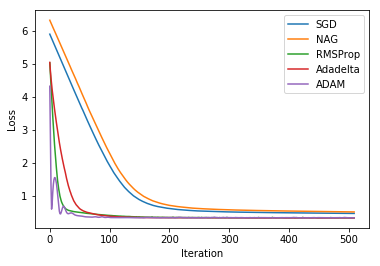

In [1]:
from sklearn import datasets as ds
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os

# C = 1
feature_size = 123


def sigmoid(input_):
    return 1 / (1 + np.exp(-1.0 * input_))


def compute_loss(x, y, w):
    # x.shape = [batch_size, feature_size + 1], y.shape = [batch_size, 1], w.shape = [feature_size + 1, 1]
    logits = np.matmul(x, w)
    loss = -np.mean(y * np.log(sigmoid(logits)) + (1 - y) * np.log(1 - sigmoid(logits)))
    return loss


def compute_gradient(x, y, w):
    # x.shape = [batch_size, feature_size + 1], y.shape = [batch_size, 1], w.shape = [feature_size + 1, 1]
    logits = np.matmul(x, w)
    output = sigmoid(logits)
    error = output - y
    gradient = np.matmul(x.transpose(), error) / len(y)
    return gradient  # gradient.shape = [feature_size + 1, 1], the same as w


global_list = {'NAG_momentum': np.zeros([feature_size + 1, 1]), 'RMS_expectation': 1, 'ADAM_s': 0, 'ADAM_r': 0,
               'ADADELDA_r': 0, 'ADADELDA_e': 0}


def optimizer(method, parameter_list, x, y, w):
    global global_list
    if method == 'SGD':
        # sgd_para_list = {'learning_rate':0.01}
        lr = parameter_list['learning_rate']
        w -= lr * compute_gradient(x, y, w)
    if method == 'NAG':
        # nag_para_list = {'miu':0.9, 'learning_rate':0.01}
        lr = parameter_list['learning_rate']
        miu = parameter_list['miu']
        momentum = global_list['NAG_momentum']
        gradient = compute_gradient(x, y, w - momentum * lr * miu)
        momentum = momentum * lr + gradient
        w -= lr * momentum
    if method == 'RMSProp':
        # rmsprop_para_list = {'delta':10e-7, 'rho':0.95, 'learning_rate':0.1}
        lr = parameter_list['learning_rate']
        expectation = global_list['RMS_expectation']
        rho = parameter_list['rho']
        delta = parameter_list['delta']
        gradient = compute_gradient(x, y, w)
        norm = np.sum(gradient**2)
        expectation = rho * expectation + (1 - rho) * norm
        global_list['RMS_expectation'] = expectation
        w -= lr * gradient / (np.sqrt(expectation) + delta)
    if method == 'ADAM':
        # adam_para_list = {'delta':10e-8, 'rho1':0.9, 'rho2':0.999, 'learning_rate':0.1}
        delta = parameter_list['delta']
        rho1 = parameter_list['rho1']
        rho2 = parameter_list['rho2']
        lr = parameter_list['learning_rate']
        s = global_list['ADAM_s']
        r = global_list['ADAM_r']
        gradient = compute_gradient(x, y, w)
        s = rho1 * s + (1 - rho1) * gradient
        r = rho2 * r + (1 - rho2) * gradient * gradient
        s_hat = s / (1 - rho1)
        r_hat = r / (1 - rho2)
        w -= (lr * s_hat) / (np.sqrt(r_hat) + delta)
        global_list['ADAM_s'] = s
        global_list['ADAM_r'] = r
    if method == 'Adadelta':
        # adadelta_para_list = {'delta':10e-7, 'miu':0.9, 'learning_rate':10}
        r = global_list['ADADELDA_r']
        e = global_list['ADADELDA_e']
        miu = parameter_list['miu']
        delta = parameter_list['delta']
        lr = parameter_list['learning_rate']
        grad = compute_gradient(x, y, w)
        r = miu * r + (1 - miu) * grad * grad
        w -= (lr * grad * np.sqrt(e + delta)) / (np.sqrt(r + delta))
        e = miu * e + (1 - miu) * e * e
        global_list['ADADELDA_r'] = r
        global_list['ADADELDA_e'] = e


if __name__ == '__main__':
    x_train, y_train = ds.load_svmlight_file('./a9a')
    x_test, y_test = ds.load_svmlight_file('./a9a.t')

    num_samples, num_features = x_train.shape
    num_test_samples, num_test_features = x_test.shape

    x_train = x_train.toarray()
    temp = np.ones(shape=[num_samples, 1], dtype=np.float32)
    x_train = np.concatenate([x_train, temp], axis=1)
    x_test = x_test.toarray()
    temp = np.zeros(shape=[num_test_samples, 1], dtype=np.float32)
    temp1 = np.ones(shape=[num_test_samples, 1], dtype=np.float32)
    x_test = np.concatenate([x_test, temp, temp1], axis=1)
    for i in range(0, len(y_train)):
        if y_train[i] == -1:
            y_train[i] = 0
    for i in range(0, len(y_test)):
        if y_test[i] == -1:
            y_test[i] = 0
    y_train = y_train.reshape([len(y_train), 1])
    y_test = y_test.reshape([len(y_test), 1])


    def shuffle_train():
        global x_train, y_train
        rng_state = np.random.get_state()
        np.random.shuffle(x_train)
        np.random.set_state(rng_state)
        np.random.shuffle(y_train)

    batch_size = 128
    data_size = num_samples
    def feed_data(batch_count):
        if (1 + batch_count) * batch_size <= data_size:
            feed_dict = {'x': x_train[batch_count * batch_size:(batch_count + 1) * batch_size],
                         'y': y_train[batch_count * batch_size:(batch_count + 1) * batch_size]}
        else:
            feed_dict = {'x': x_train[batch_count * batch_size:data_size],
                         'y': y_train[batch_count * batch_size:data_size]}
        return feed_dict

    methods = ['SGD', 'NAG', 'RMSProp', 'Adadelta', 'ADAM']
    sgd_para_list = {'learning_rate': 0.01}
    nag_para_list = {'miu': 0.9, 'learning_rate': 0.01}
    rmsprop_para_list = {'delta': 10e-7, 'rho': 0.95, 'learning_rate': 0.1}
    adam_para_list = {'delta': 10e-8, 'rho1': 0.9, 'rho2': 0.999, 'learning_rate': 0.1}
    adadelta_para_list = {'delta': 10e-7, 'miu': 0.9, 'learning_rate': 10}
    para_list = {'SGD': sgd_para_list, 'NAG': nag_para_list, 'RMSProp': rmsprop_para_list,
                 'Adadelta': adadelta_para_list, 'ADAM': adam_para_list}
    for method in methods:
        iters = []
        test_errors = []
        w = np.random.rand(feature_size+1, 1)
        parameter_list = para_list[method]
        count = 0
        for i in range(0, 2):
            shuffle_train()
            for batch_count in range(0, int(data_size / batch_size ) + 1):
                feed_dict = feed_data(batch_count)
                iters.append(count)
                count += 1
                optimizer(method=method, parameter_list=parameter_list, x=feed_dict['x'], y=feed_dict['y'], w=w)
                test_errors.append(compute_loss(x_test, y_test, w))
        plt.plot(iters, test_errors, label=method)


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()